In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime

import tensorflow as tf
import os
from glob import glob
from pathlib import Path
from collections import defaultdict
from pprint import pprint
from random import choice, sample
import cv2
from google.colab.patches import cv2_imshow

In [2]:
from google.colab import drive
drive.mount('/gdrive') 

Mounted at /gdrive


In [3]:
import cv2;
import math;
import numpy as np;

def DarkChannel(im,sz):
    b,g,r = cv2.split(im)
    dc = cv2.min(cv2.min(r,g),b);
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(sz,sz))
    dark = cv2.erode(dc,kernel)
    return dark

def AtmLight(im,dark):
    [h,w] = im.shape[:2]
    imsz = h*w
    numpx = int(max(math.floor(imsz/1000),1))
    darkvec = dark.reshape(imsz);
    imvec = im.reshape(imsz,3);

    indices = darkvec.argsort();
    indices = indices[imsz-numpx::]

    atmsum = np.zeros([1,3])
    for ind in range(1,numpx):
       atmsum = atmsum + imvec[indices[ind]]

    A = atmsum / numpx;
    return A

def TransmissionEstimate(im,A,sz):
    omega = 0.95;
    im3 = np.empty(im.shape,im.dtype);

    for ind in range(0,3):
        im3[:,:,ind] = im[:,:,ind]/A[0,ind]

    transmission = 1 - omega*DarkChannel(im3,sz);
    return transmission

def Guidedfilter(im,p,r,eps):
    mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r));
    mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r));
    mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r));
    cov_Ip = mean_Ip - mean_I*mean_p;

    mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r));
    var_I   = mean_II - mean_I*mean_I;

    a = cov_Ip/(var_I + eps);
    b = mean_p - a*mean_I;

    mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r));
    mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r));

    q = mean_a*im + mean_b;
    return q;

def TransmissionRefine(im,et):
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY);
    gray = np.float64(gray)/255;
    r = 60;
    eps = 0.0001;
    t = Guidedfilter(gray,et,r,eps);

    return t;

def Recover(im,t,A,tx = 0.1):
    res = np.empty(im.shape,im.dtype);
    t = cv2.max(t,tx);

    for ind in range(0,3):
        res[:,:,ind] = (im[:,:,ind]-A[0,ind])/t + A[0,ind]

    return res



def get_dehazed_image(image_path):
  src = cv2.imread(image_path);
  I = src.astype('float64')/255;
  dark = DarkChannel(I,15);
  A = AtmLight(I,dark);
  te = TransmissionEstimate(I,A,15);
  t = TransmissionRefine(src,te);
  J = Recover(I,t,A,0.1);
  return J


In [4]:
from os import listdir
from os.path import isfile, join
root = '/gdrive/MyDrive/Deep Learning Competition/'
dry_run_folder = os.path.join(root, 'new_dry_run/images')
dry_run_images = [join(dry_run_folder, f) for f in listdir(dry_run_folder) if isfile(join(dry_run_folder, f))]
image_to_predicted_bb = {}

In [5]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# Print Tensorflow version
print(tf.__version__)
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector = hub.load(module_handle).signatures['default']

2.8.0
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [33]:
dark_channel_prior = os.path.join(root, 'dark_channel_prior')
all_images = '/gdrive/MyDrive/Deep Learning Competition/train/haze_images/'

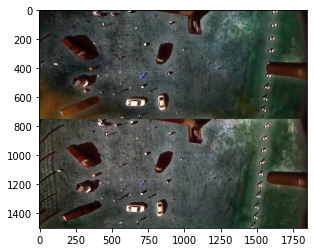

In [44]:
# Path(dark_channel_prior).mkdir(parents=True, exist_ok=True)

all_input_images = glob(all_images + "/*.jpg")
i = 0
for image in all_input_images:
  i = i + 1
  clear_image = get_dehazed_image(image)
  plt.imshow(clear_image)
  if i >3:
    break

  # print(clear_image)

  #cv2_imshow(clear_image)
  # prefix = str(Path(image).stem)
  # clear_image_path = "clear" + prefix + ".jpg"
  # clear_image_file = os.path.join(dark_channel_prior, f'{clear_image_path}')
  # cv2.imwrite(clear_image_file, clear_image) 

In [ ]:
for image_path in dry_run_images:
  image = get_dehazed_image(image_path)

In [6]:
def filter_coords(result, threshold = 0):
  '''
    A helper method which extracts the bounding boxes and threshold confidence scores
    from the data structure returned from the pretrained model

    Parameters:
            result : Output of the pretrained tensor flow model
            threshold : Optional threshold confidence above which bounding boxes are selected
    Returns:
            The list of coordinates of the detected objects and the threshold score
  '''
  class_entities = result['detection_class_entities']
  detection_scores = result['detection_scores']
  bounding_boxes = result['detection_boxes']
  detection_boxes_with_thresholds = []
  for class_entity, detection_score, bounding_box in zip(class_entities, detection_scores, bounding_boxes):
    if class_entity in [b'Vehicle', b'Car'] and detection_score > threshold:
      detection_boxes_with_thresholds.append((bounding_box, detection_score))
  return detection_boxes_with_thresholds

In [27]:
image_to_predicted_bb = {}

In [28]:
for image_path in dry_run_images:
  image = get_dehazed_image(image_path)
  image = tf.convert_to_tensor(
      image
  )
  image  = tf.image.convert_image_dtype(image, tf.float32)[tf.newaxis, ...]

  result = detector(image)

  result = {key:value.numpy() for key,value in result.items()}

  coords = filter_coords(result, threshold = 0.055)

  image_to_predicted_bb[image_path] = coords

In [29]:
im_height, im_width = 750, 1845
def visualize_predicted_image(image_path, coords):
  '''
  Displays the image with the detected object boundaries marked

    Parameters:
            img_path : Path of the image
            coords : list of detected bounding boxes
  '''
  image = cv2.imread(image_path)
  #im_height, im_width = image.shape[:2]
  for coord in coords:
    ymin, xmin, ymax, xmax = coord[0]
    #The actual model used for detecting bounding box
    #returns scaled coordinates. Hence we are multiplying 
    #the coordinates by the image width and height
    start_point = (int(xmin*im_width)), (int(ymin*im_height))
    end_point = (int(xmax*im_width)), (int(ymax*im_height))
    # Blue color in BGR
    color = (255, 0, 0)
      
    # Line thickness of 2 px
    thickness = 2

    # Using cv2.rectangle() method
    # Draw a rectangle with blue line borders of thickness of 2 px
    cv2.rectangle(image, start_point, end_point, color, thickness)

  cv2_imshow(image)

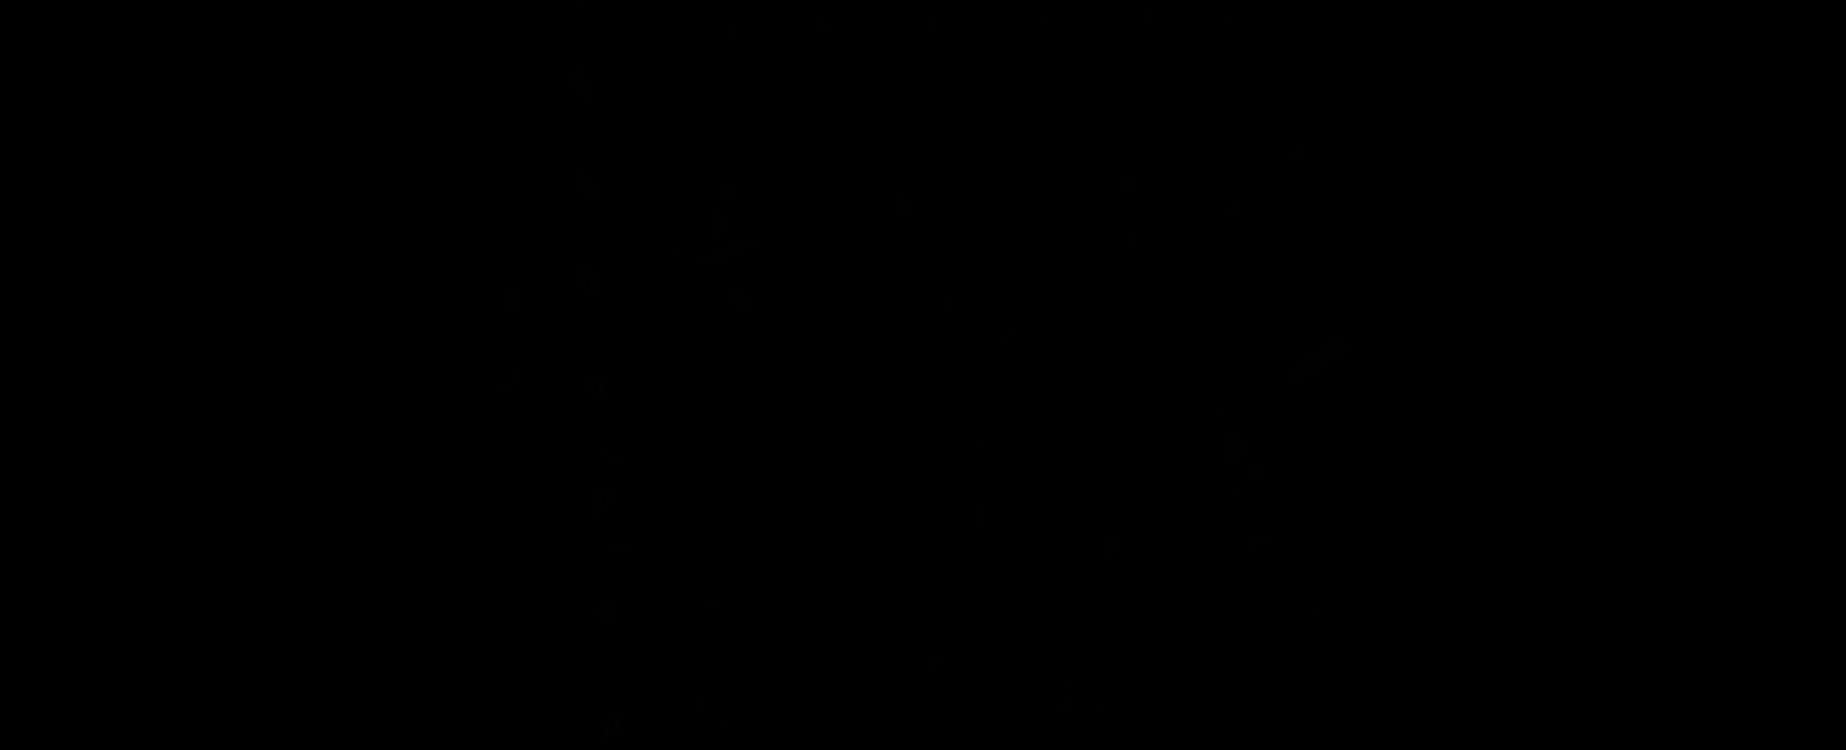

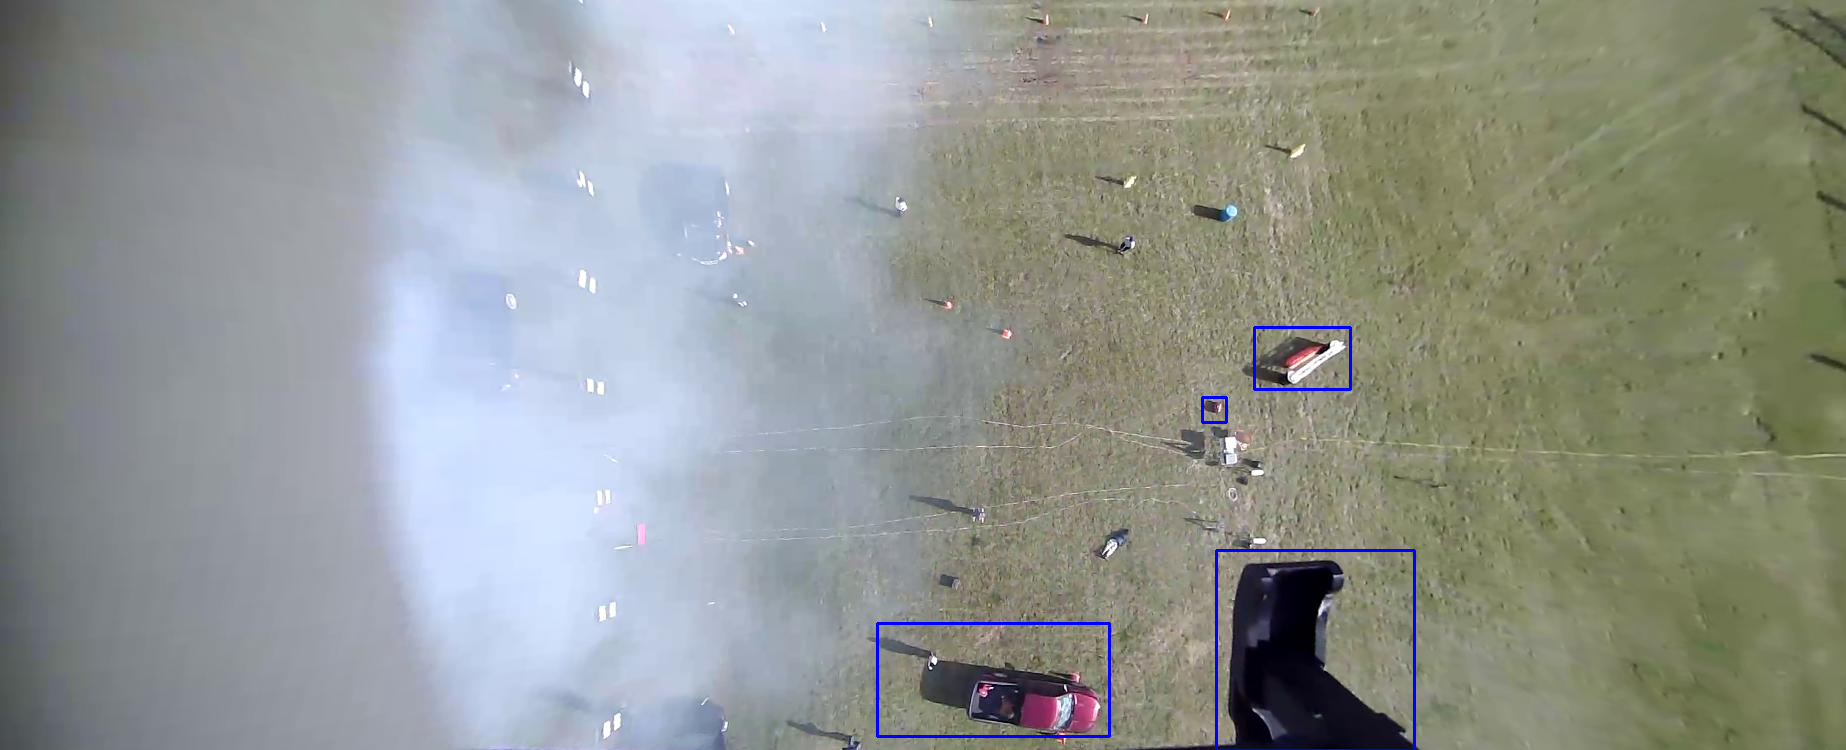

In [30]:
#image_path = os.path.join(haze_images, '035.jpg')
## Removing Haze:
image_path = '/gdrive/MyDrive/2nd Semester/Coursework/Deep Learning/Competition/Submission Feb 20th Onwards/UG2+_Track1/train/dry-run-1/new_068.jpg'

####

image = get_dehazed_image(image_path)
cv2_imshow(image)
# image = image_dehazer.remove_haze(image)

image = tf.convert_to_tensor(
    image
)
converted_img  = tf.image.convert_image_dtype(image, tf.float32)[tf.newaxis, ...]
result = detector(converted_img)

result = {key:value.numpy() for key,value in result.items()}

f = filter_coords(result, threshold = 0.055)
visualize_predicted_image(image_path, f)

In [31]:
results = os.path.join(root, 'results_dark_channel')
im_height, im_width = 750, 1845
Path(results).mkdir(parents=True, exist_ok=True)

for image in image_to_predicted_bb:
  filename = Path(image).stem
  new_file = os.path.join(results, f'{filename}.txt')
  coords = image_to_predicted_bb[image]
  try:
    os.remove(filename)
  except OSError:
    pass
  f = open(new_file, "w+")
  for coord in coords:
    ymin, xmin, ymax, xmax = coord[0]
    threshold = coord[1]
    format_string = f'vehicle {xmin*im_width} {ymin*im_height} {xmax*im_width} {ymax*im_height} {threshold}\n'
    f = open(new_file, "a+")
    f.write(format_string)
    f.close()

Mounted at /gdrive
